### Import Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, scale # feature scaling for range
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2score, mean_squared_error
!pip install category_encoders
!pip install graphviz

### ** Read in all preprocessed model-ready files if want to skip data prep section below **
### ** To go directly to models (original columns) read in files and go to line 102 **

In [ ]:
X_train_all_encoded2 = pd.read_csv('./data/X_train_all_encoded2.csv')
X_test_all_encoded2 = pd.read_csv('./data/X_test_all_encoded2.csv')
y_train = pd.read_csv('./data/y_train.csv')
y_test = pd.read_csv('./data/y_train.csv')

### Data prep: original Kaggle train set

In [46]:
# Train set
train = pd.read_csv("./data/train_original.csv")
train = pd.DataFrame(train)
train.shape

(1460, 81)

In [47]:
numeric_features = train.select_dtypes(include = ['int64','float64'])
numeric_features = pd.DataFrame(numeric_features, columns=numeric_features.columns)
numeric_features.shape

(1460, 38)

In [48]:
categorical_features = train.select_dtypes(include = 'O')
categorical_features = pd.DataFrame(categorical_features, columns=categorical_features.columns)
categorical_features.shape

(1460, 43)

### StandardScaler

In [54]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

numeric_features_scaled = sc.fit_transform(numeric_features)
numeric_features_scaled = sc.transform(numeric_features)
numeric_features_scaled = pd.DataFrame(numeric_features_scaled, columns=numeric_features.columns)
numeric_features_scaled.shape

(1460, 38)

In [55]:
train_scaled = pd.concat([numeric_features_scaled, categorical_features], axis=1)
train_scaled.to_csv("./data/train_scaled.csv", index=False)


In [57]:
X = train_scaled.drop('SalePrice', axis=1)
X.shape

(1460, 80)

In [58]:
y = train_scaled['SalePrice']
y.shape

(1460,)

### Percentage Missing

              Number of missing  Percent missing
PoolQC                     1453            99.52
MiscFeature                1406            96.30
Alley                      1369            93.77
Fence                      1179            80.75
FireplaceQu                 690            47.26
LotFrontage                 259            17.74
GarageType                   81             5.55
GarageFinish                 81             5.55
GarageQual                   81             5.55
GarageCond                   81             5.55
GarageYrBlt                  81             5.55
BsmtExposure                 38             2.60
BsmtFinType2                 38             2.60
BsmtCond                     37             2.53
BsmtFinType1                 37             2.53
BsmtQual                     37             2.53
MasVnrArea                    8             0.55
MasVnrType                    8             0.55
Electrical                    1             0.07


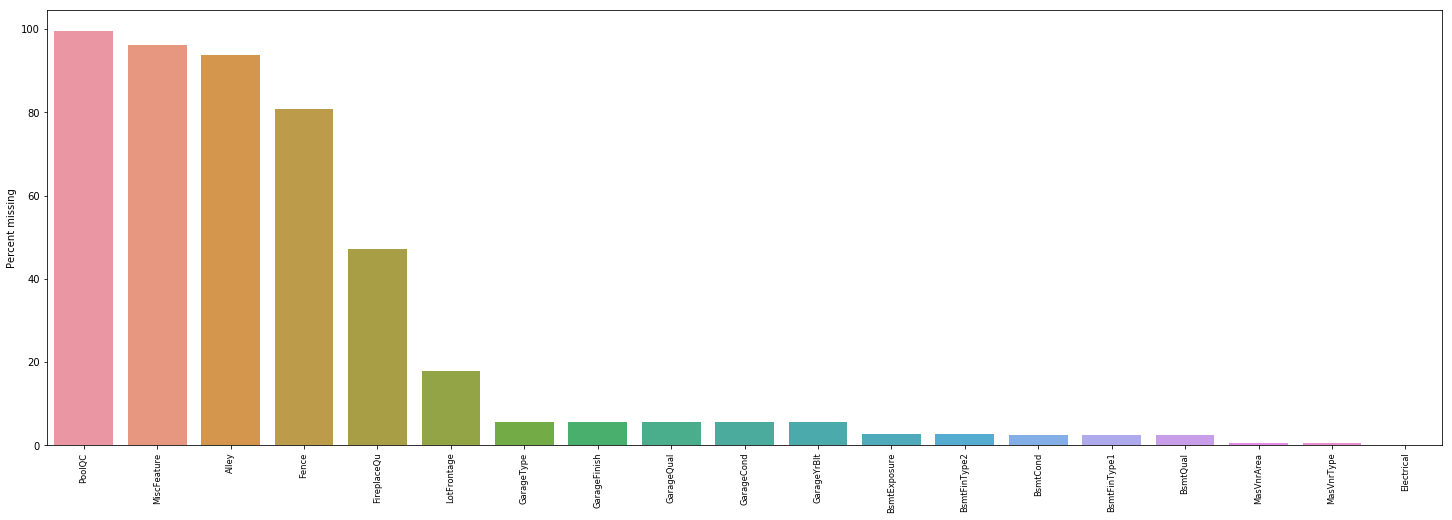

In [59]:
missing = pd.DataFrame({'Number of missing': pd.isnull(train_scaled).sum(axis = 0)[pd.isnull(train_scaled).sum(axis = 0) > 0],
              'Percent missing': round(pd.isnull(train_scaled).sum(axis = 0)[pd.isnull(train_scaled).sum(axis = 0) > 0]/train_scaled.shape[0]*100,2)})
missingDesc = missing.sort_values(by=['Percent missing'], ascending=False)
print(missingDesc)

plt.figure(figsize = (25, 8))  
p = sns.barplot(missingDesc.index, missingDesc['Percent missing'])
for label in p.get_xticklabels():
    p.set_xticklabels(missingDesc.index, rotation=90, fontsize='small')

In [60]:
PoolIndex = train[train['PoolArea']!=0].index  # Only these houses should receive a rating for pool qualiity, all others should be 'NA' rather than missing values.loc[np.logical_not(df_all_1.index.isin(PoolIndex)),'PoolQC'] = 'NA'
train.loc[np.logical_not(train.index.isin(PoolIndex)),'PoolQC'] = 'NA' #change from NaN to 'NA', meaning different
#train['PoolQC']

# # Impute the 3 true missing values
train['PoolQC'] = train['PoolQC'].fillna(train.PoolQC[PoolIndex].mode()[0])

NA    1453
Gd       3
Fa       2
Ex       2
Name: PoolQC, dtype: int64

### Split into Train and Test Set

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [96]:
y_train.to_csv('./data/y_train.csv', index=False)
y_test.to_csv('./data/y_test.csv', index=False)

In [97]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
y_test.shape

(978, 80)
(482, 80)
(978,)


(482,)

### Create temporary 'train' columns to align train and test set before categorical encoding, then drop 'train' 

In [64]:
X_train['train'] = 1
X_test['train'] = 0

In [65]:
combined = pd.concat([X_train, X_test])
combined.isna().sum().sum()

6965

In [66]:
# Commbined binary encoding
import category_encoders as ce
X_combined_binary = combined.copy()
cols_binaryenc = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
                 'Condition2', 'BldgType', 'GarageType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                 'SaleType', 'SaleCondition']
encoder2 = ce.BinaryEncoder(cols=cols_binaryenc)
X_combined_binary = encoder2.fit_transform(X_combined_binary)
X_combined_binary.shape
X_combined_binary.isna().sum().sum()

6876

In [67]:
# Combined OHE encoding
X_combined_ohe = X_combined_binary.copy()

cols_ohe = ['Street', 'CentralAir']
encoder3 = ce.OneHotEncoder(cols=cols_ohe)
X_combined_ohe = encoder3.fit_transform(X_combined_ohe)
print(X_combined_ohe.shape)
X_combined_ohe.isna().sum().sum()

(1460, 143)


6876

In [68]:
# Combined ordinal encoding
X_combined_ordinal = X_combined_ohe.copy()

cols_ordinal = ['LotShape', 'Utilities', 'LandSlope', 'ExterCond',
               'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
                'HeatingQC', 'Electrical', 'ExterQual', 'KitchenQual', 'Functional', 'FireplaceQu',
                'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']

encoder4 = ce.ordinal.OrdinalEncoder(cols=cols_ordinal)
X_combined_ordinal = encoder4.fit_transform(X_combined_ordinal)
print(X_combined_ordinal.shape)
X_combined_ordinal.isna().sum().sum()

(1460, 143)


4302

In [69]:
X_train_all_encoded = X_combined_ordinal[X_combined_ordinal['train'] == 1]

In [70]:
X_test_all_encoded = X_combined_ordinal[X_combined_ordinal['train'] == 0]

### Drop 'train' column to separate concatenated train and test set used for categorical encoding

In [71]:
X_train_all_encoded.drop(['train'], axis=1, inplace=True)
X_test_all_encoded.drop(['train'], axis=1, inplace=True)

In [72]:
print(X_train_all_encoded.shape) # should be (978, 142 if 'train' column dropped)
X_test_all_encoded.shape # should be (482, 142 if 'train' column dropped)

(978, 142)


(482, 142)

In [73]:
print(X_train_all_encoded.isna().sum().sum())
X_test_all_encoded.isna().sum().sum()

2879


1423

### Imputation: GarageYrBlt/Other Features, Drop Variables

In [74]:
# LotFrontage : NA most likely means no lot frontage
X_train_all_encoded.loc[:, "LotFrontage"] = X_train_all_encoded.loc[:, "LotFrontage"].fillna(0)
X_train_all_encoded.loc[:, "MasVnrArea"] = X_train_all_encoded.loc[:, "MasVnrArea"].fillna(0)
X_train_all_encoded.loc[:,'Condition2_3'] = X_train_all_encoded.loc[:,'Condition2_3'].fillna(0)
X_train_all_encoded.loc[:,'SaleType_4'] = X_train_all_encoded.loc[:,'SaleType_4'].fillna(0)

# store index for all houses with missing GarageYrBlt
temp = X_train_all_encoded[X_train_all_encoded.GarageYrBlt.isnull() == True].index 
X_train_all_encoded["GarageYrBlt"]= np.where((X_train_all_encoded.GarageYrBlt.isnull() == True), X_train_all_encoded.YearBuilt,X_train_all_encoded.GarageYrBlt).astype('int64')
X_train_all_encoded["GarageYrBlt"][:10,] # impute YearBuilt where missing values in GarageYrBlt, otherwise, use GarageYrBlt

# HERE DROP Alley, MiscFeature, MiscVal, Fence, 
X_train_all_encoded.drop(['Id','Alley', 'MiscFeature', 'MiscVal', 'Fence'], axis=1, inplace=True)

In [75]:
X_train_all_encoded.to_csv('./data/X_train_all_encoded.csv', index=False)

In [76]:
print(X_train_all_encoded.shape) #(978, 137) cell above dropped 'Id', 'MiscFeature', etc
X_train_all_encoded.isna().sum().sum() 

(978, 137)


0

In [77]:
# LotFrontage : NA most likely means no lot frontage
X_test_all_encoded.loc[:, "LotFrontage"] = X_test_all_encoded.loc[:, "LotFrontage"].fillna(0)
X_test_all_encoded.loc[:, "MasVnrArea"] = X_test_all_encoded.loc[:, "MasVnrArea"].fillna(0)
# X_test_all_encoded.loc[:,'Condition2_3'] = X_test_all_encoded.loc[:,'Condition2_3'].fillna(0)
#X_test_all_encoded.loc[:,'SaleType_4'] = X_test_all_encoded.loc[:,'SaleType_4'].fillna(0)
# store index for all houses with missing GarageYrBlt
temp = X_test_all_encoded[X_test_all_encoded.GarageYrBlt.isnull() == True].index 
X_test_all_encoded["GarageYrBlt"]= np.where((X_test_all_encoded.GarageYrBlt.isnull() == True), X_test_all_encoded.YearBuilt,X_test_all_encoded.GarageYrBlt).astype('int64')
X_test_all_encoded["GarageYrBlt"][:10,] # impute YearBuilt where missing values in GarageYrBlt, otherwise, use GarageYrBlt

# HERE DROP Alley, MiscFeature, MiscVal, Fence, 
X_test_all_encoded.drop(['Id','Alley', 'MiscFeature', 'MiscVal', 'Fence'], axis=1, inplace=True)
print(X_test_all_encoded.shape) #(482, 137) line above dropped 'Id', 'MiscFeature', etc
X_test_all_encoded.isna().sum().sum() 

(482, 137)


0

In [78]:
X_test_all_encoded.to_csv('./data/X_test_all_encoded.csv', index=False)

In [79]:
print(X_test_all_encoded.shape)
X_test_all_encoded.isna().sum().sum()

(482, 137)


0

### Filter by Variance, drop if equals 0

In [80]:
X_train_all_encoded.var().sort_values(ascending=True) == 0

MSSubClass_0        True
LotConfig_0         True
Neighborhood_0      True
Condition1_0        True
Condition2_0        True
BldgType_0          True
RoofMatl_0          True
Exterior1st_0       True
RoofStyle_0         True
MasVnrType_0        True
Foundation_0        True
GarageType_0        True
SaleType_0          True
SaleCondition_0     True
MSZoning_0          True
Utilities          False
SaleType_1         False
Exterior2nd_0      False
Street_1           False
Street_2           False
Condition2_1       False
Condition2_2       False
Condition1_1       False
RoofMatl_3         False
Condition2_3       False
HouseStyle_0       False
RoofMatl_1         False
RoofMatl_2         False
MasVnrType_1       False
PoolQC             False
RoofStyle_1        False
Foundation_1       False
SaleCondition_1    False
LandContour_0      False
SaleType_2         False
BldgType_1         False
MSZoning_1         False
Exterior2nd_1      False
Condition1_2       False
LandContour_1      False


### Drop: Zero Variance 

In [81]:
X_train_all_encoded2 = X_train_all_encoded.drop(['MSSubClass_0', 'MSZoning_0', 'LotConfig_0', 'Neighborhood_0',
               'Condition1_0', 'Condition2_0', 'BldgType_0', 'RoofStyle_0', 'RoofMatl_0', 'Exterior1st_0',
            'MasVnrType_0', 'Foundation_0', 'GarageType_0', 'SaleType_0', 'SaleCondition_0'], axis=1)

In [82]:
X_train_all_encoded2.to_csv('./data/X_train_all_encoded2.csv', index=False)
X_train_all_encoded2.head()

,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,MSZoning_1,MSZoning_2,MSZoning_3,Street_1,Street_2,LotShape,LandContour_0,LandContour_1,LandContour_2,Utilities,LotConfig_1,LotConfig_2,LotConfig_3,LandSlope,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition2_1,Condition2_2,Condition2_3,BldgType_1,BldgType_2,BldgType_3,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofMatl_1,RoofMatl_2,RoofMatl_3,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,MasVnrType_1,MasVnrType_2,MasVnrType_3,ExterQual,ExterCond,Foundation_1,Foundation_2,Foundation_3,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir_1,CentralAir_2,Electrical,KitchenQual,Functional,FireplaceQu,GarageType_1,GarageType_2,GarageType_3,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleCondition_1,SaleCondition_2,SaleCondition_3
0,0,0,0,1,0.409895,-0.172064,-0.071836,1.280685,-0.273836,-1.059473,0.289026,0.700441,-0.288653,-0.892521,-0.276885,-0.281085,-0.795163,-0.120242,-0.878476,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,-0.318683,-0.951226,0,0.311725,0.032844,0.205557,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.489110,1.645210,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,0,0,1
1,0,0,1,0,-0.002058,-0.211952,-0.795151,-0.517200,1.183477,1.072482,-0.572835,-0.521206,-0.288653,0.785029,0.142674,-0.110302,-0.795163,-0.120242,-0.752833,-0.819964,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,-0.318683,-0.951226,1,-2.365440,-2.212963,-0.752176,-0.251539,-0.359325,-0.116339,-0.270208,-0.068692,2.100892,-0.614439,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,2,0,0,1,2,1,2,2,1,1,1,1,0,1,2,1,1,0,1,0,2,2,2,1,1,0,0,1,0,0,1,0
2,0,0,1,0,0.121528,-0.183289,0.651479,-0.517200,1.117235,0.975575,0.686807,-0.973018,-0.288653,2.374287,1.273661,1.173158,-0.795163,-0.120242,0.191388,-0.819964,-0.241061,0.789741,-0.761621,0.163779,-0.211454,0.296763,-0.951226,1,1.650307,1.689127,0.907895,0.186307,-0.359325,-0.116339,-0.270208,-0.068692,-0.859110,-1.367655,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,2,2,0,0,1,2,1,3,3,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,0,1,1
3,0,0,1,0,0.368699,-0.022833,-0.795151,1.280685,-0.207594,-0.962566,0.355322,0.860549,-0.288653,-0.747631,0.035504,-0.231920,-0.795163,-0.120242,-0.842306,1.107810,-0.241061,-1.026041,1.227585,0.163779,-0.211454,-0.318683,-0.951226,0,0.311725,0.196601,-0.752176,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.119110,-0.614439,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,2,0,1,0,1,1,2,2,1,1,2,1,0,1,2,1,1,0,0,1,1,1,1,1,1,0,0,0,1,0,1,1
4,0,0,1,0,0.286309,-0.050795,-0.795151,-0.517200,0.090492,-0.478030,-0.572835,1.375965,0.474072,-0.842715,0.756052,0.585768,-0.795163,-0.120242,-0.240745,1.107810,-0.241061,-1.026041,-0.761621,-1.062465,-0.211454,-0.318683,0.600495,0,0.311725,-0.257239,1.163290,-0.130754,-0.359325,-0.116339,-0.270208,-0.068692,-0.859110,-1.367655,0,0,1,1,0,1,0,0,1,1,0,0,1,2,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,2,0,1,0,2,1,3,2,2,1,3,1,0,1,2,1,2,0,0,1,1,1,1,1,1,0,0,0,1,0,1,1


In [85]:
X_test_all_encoded2 = X_test_all_encoded.drop(['MSSubClass_0', 'MSZoning_0', 'LotConfig_0', 'Neighborhood_0',
               'Condition1_0', 'Condition2_0', 'BldgType_0', 'RoofStyle_0', 'RoofMatl_0', 'Exterior1st_0',
            'MasVnrType_0', 'Foundation_0', 'GarageType_0', 'SaleType_0', 'SaleCondition_0'], axis=1)
X_test_all_encoded2.shape #(482, 122)

(482, 122)

In [86]:
X_test_all_encoded2.to_csv('./data/X_test_all_encoded2.csv', index=False)
print(X_test_all_encoded2.shape) #(482, 122)

### ** MODELS: Original features (with binary/OHE/ordinal encoding)
### ** GridSearchCV: Ridge, Lasso, ElasticNet, RandomForest, GradientBoost, SVR

### Ridge

In [102]:
ridge = Ridge()
params1 = {'alpha': np.arange(0, 10),
          'max_iter': [10, 50, 100, 200, 300, 400, 500, 600, 700],
          'solver': ['cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

grid1 = GridSearchCV(ridge, params1, n_jobs=-1)

grid1.fit(X_train_all_encoded2, y_train)
pred=grid1.predict(X_test_all_encoded2)

train_score = grid1.score(X_train_all_encoded2, y_train)
test_score = grid1.score(X_test_all_encoded2, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is is {:.4}'.format(mae))

grid1_best_params = grid1.best_params_
print(grid1_best_params)
print('GridSearchCV best_score is {:.4%}'.format(grid1.best_score_))

The train score is 0.8529
The test score is 0.8177
The R-squared is 0.8177
The root mean squared is 0.4607
The mean squared error is 0.2122
The mean absolute error is is 0.2595
{'alpha': 0.5, 'max_iter': 10, 'solver': 'saga'}
GridSearchCV best_score is 69.9202%


### Lasso

In [103]:
lasso = Lasso(random_state=42)
params2 = {'alpha': np.arange(0, 10),
          'max_iter': np.arange(1, 700, 5),
          'selection':['cyclic', 'random']}

grid2 = GridSearchCV(lasso, params2, n_jobs=-1)

grid2.fit(X_train_all_encoded2, y_train)
pred=grid2.predict(X_test_all_encoded2)

train_score = grid2.score(X_train_all_encoded2, y_train)
test_score = grid2.score(X_test_all_encoded2, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is is {:.4}'.format(mae))

grid2_best_params = grid2.best_params_
print(grid2_best_params)
print('GridSearchCV best_score is {:.4%}'.format(grid2.best_score_))

The train score is 0.8838
The test score is 0.8169
The R-squared is 0.8169
The root mean squared is 0.4617
The mean squared error is 0.2132
The mean absolute error is is 0.273
{'alpha': 0, 'max_iter': 696, 'selection': 'cyclic'}
GridSearchCV best_score is 32.1581%


### ElasticNet

In [104]:
elastic = ElasticNet(random_state=42)
params4 = {"alpha": np.arange(0, 10),
          "max_iter": np.arange(1, 700, 5),
          'l1_ratio': [0.1, 0.4, 0.7, 0.9]}

grid4 = GridSearchCV(elastic, params4, n_jobs=-1)

grid4.fit(X_train_all_encoded2, y_train)
pred=grid4.predict(X_test_all_encoded2)

train_score = grid4.score(X_train_all_encoded2, y_train)
test_score = grid4.score(X_test_all_encoded2, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is is {:.4}'.format(mae))

grid4_best_params = grid4.best_params_
print(grid4_best_params)
print('GridSearchCV best_score is {:.4%}'.format(grid4.best_score_))

The train score is 0.7468
The test score is 0.7732
The R-squared is 0.7732
The root mean squared is 0.5138
The mean squared error is 0.264
The mean absolute error is is 0.2923
{'alpha': 1, 'l1_ratio': 0.1, 'max_iter': 1}
GridSearchCV best_score is 71.4078%


### Random Forest Regressor

In [ ]:
randomforest = RandomForestRegressor(verbose=0)
params5 = {"criterion": ['mae','mse'],
          "min_samples_leaf": range(1, 10),
          "min_samples_split": np.linspace(start=2, stop=30,
                    num=15, dtype=int),
          "max_depth": range(1,10),
          "n_estimators": np.linspace(1, 1000, num=15, dtype=int),
          "max_features": range(5, 80, 5)}
#           'oob_score'= True}
 
grid5 = RandomizedSearchCV(randomforest, params5)

grid5.fit(X_train_all_encoded2, y_train)
pred=grid5.predict(X_test_all_encoded2)

train_score = grid5.score(X_train_all_encoded2, y_train)
test_score = grid5.score(X_test_all_encoded2, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is is {:.4}'.format(mae))

grid5_best_params = grid5.best_params_
print(grid5_best_params)
print('RandomizedSearchCV best_score is {:.4%}'.format(grid5.best_score_))

### Feature Importances: RandomForest (original)

In [150]:
randomforest = RandomForestRegressor(n_estimators=857, max_depth=9, max_features=35, min_samples_leaf=1, min_samples_split=18)
randomforest.fit(X_train_all_encoded2, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=35, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=18, min_weight_fraction_leaf=0.0,
           n_estimators=857, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [153]:
sorted_importance_encoded2 = sorted(zip(X_train_all_encoded2.columns, randomforest.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_encoded2 = sorted_importance_encoded2[:15]
sorted_importance_encoded2

[('OverallQual', 0.25440508222068875),
 ('GrLivArea', 0.14410731810696786),
 ('GarageCars', 0.08642456375082082),
 ('ExterQual', 0.06077682202047429),
 ('YearBuilt', 0.058589323217171946),
 ('TotalBsmtSF', 0.05618227793882132),
 ('GarageArea', 0.04679166147970109),
 ('1stFlrSF', 0.039557447044666356),
 ('BsmtFinSF1', 0.02747302768559306),
 ('FullBath', 0.01878585939950299),
 ('2ndFlrSF', 0.0187267296387199),
 ('LotArea', 0.018419259870866823),
 ('YearRemodAdd', 0.016469022661331427),
 ('BsmtQual', 0.013707253027174238),
 ('TotRmsAbvGrd', 0.011013626497384386)]

Text(0.5, 1.0, 'RandomForest Feature Importance (Original, no flags or scores)')

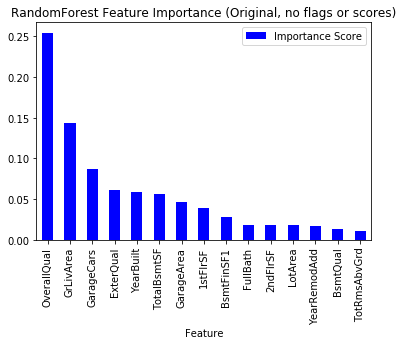

In [154]:
x, y = zip(*sorted_importance_encoded2)
barplot_encoded_encoded2 = pd.DataFrame({'Feature': x, 'Importance Score':y}).plot.bar(x='Feature', y='Importance Score')
plt.title('RandomForest Feature Importance (Original, no flags or scores)')

### Gradient Boosting Regressor

In [155]:
gbm6 = GradientBoostingRegressor()
params6 = {"criterion": ['mae','mse'],
                       "min_samples_leaf": range(1, 10),
                       "min_samples_split": np.linspace(start=2, stop=30,
                                        num=15, dtype=int),
                       "max_depth": range(1,10),
                       "alpha": [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],
                       "n_estimators": np.linspace(1, 1000, num=15, dtype=int),
                        "subsample": [0.8, 0.9, 1.0],
                       "max_features": range(5, 80, 5)}

grid6 = RandomizedSearchCV(gbm6, params6)

grid6.fit(X_train_all_encoded2,y_train)
pred=grid6.predict(X_test_all_encoded2)

train_score = grid6.score(X_train_all_encoded2, y_train)
test_score = grid6.score(X_test_all_encoded2, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is {:.4}'.format(mae))

grid6_best_params = grid6.best_params_
print(grid6_best_params)
print('RandomizedSearchCV best_score is {:.4%}'.format(grid6.best_score_))

The train score is 0.917
The test score is 0.8967
The R-squared is 0.8967
The root mean squared is 0.3467
The mean squared error is 0.1202
The mean absolute error is 0.1983
{'subsample': 0.8, 'n_estimators': 857, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 5, 'max_depth': 2, 'criterion': 'mae', 'alpha': 0.3}
RandomizedSearch best_score is 85.3520%


### Feature Importances: GradientBoost (original)

In [165]:
gbm6 = GradientBoostingRegressor()

In [166]:
gbm6.fit(X_train_all_encoded2, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [169]:
sorted_importance_gbm_encoded2 = sorted(zip(X_train_all_encoded2.columns, gbm6.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_gbm_encoded2 = sorted_importance_gbm_encoded2[:15]
sorted_importance_gbm_encoded2

[('OverallQual', 0.5075144836443946),
 ('GrLivArea', 0.14381647354276852),
 ('GarageCars', 0.05147541670663904),
 ('TotalBsmtSF', 0.04909407569098134),
 ('BsmtFinSF1', 0.032918965092399104),
 ('1stFlrSF', 0.032189177045525236),
 ('YearBuilt', 0.02648858122168825),
 ('2ndFlrSF', 0.017386463028249213),
 ('LotArea', 0.01712304672522222),
 ('YearRemodAdd', 0.01640480755778557),
 ('GarageType_2', 0.010957185092333519),
 ('ScreenPorch', 0.008801373173803528),
 ('BsmtQual', 0.0077430224774867416),
 ('Fireplaces', 0.0056838305911224),
 ('LotFrontage', 0.005324133137201849)]

Text(0.5, 1.0, 'GradientBoost Feature Importance (Original, no flags or scores)')

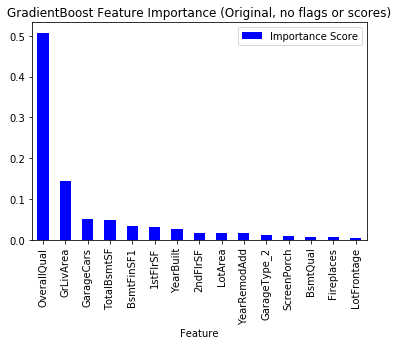

In [170]:
x, y = zip(*sorted_importance_gbm_encoded2)
barplot_encoded_gbm_encoded2 = pd.DataFrame({'Feature': x, 'Importance Score':y}).plot.bar(x='Feature', y='Importance Score')
plt.title('GradientBoost Feature Importance (Original, no flags or scores)')

### Support Vector Regression

In [ ]:
from sklearn.svm import SVR

In [ ]:
svrsearch = SVR()
params7a = {'C': [0.001, 1, 10, 100, 1000],
           'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 0, 10, 100, 1000, 10000, 100000],
           'kernel': ['poly'],
          'degree': [1, 2, 3, 4, 5]
           }
params7b = {'C': [0.001, 1, 10, 100, 1000],
          'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 0, 10, 100, 1000, 10000, 100000],
          'gamma': [100000, 10000, 1000, 100, 10, 1, 0.001, 0.0001],
           'kernel': ['rbf']}

In [ ]:
# First set of GridSearchCV parameters

gridsearch_svm7a = model_selection.GridSearchCV(svrsearch, params7a, cv=3, iid=True, n_jobs=-1)
gridsearch_svm7a.fit(X_train_tree_high, y_train)

train_score = gridsearch_svm7a.score(X_train_tree_high, y_train)
test_score = gridsearch_svm7a.score(X_test_tree_high, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse = np.sqrt(mean_squared_error(y_test,pred))
mse = mean_squared_error(y_test,pred)
mae = mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is {:.4}'.format(mae))

gridsearch_best_params7a = gridsearch_svm7a.best_params_
print(gridsearch_best_params7a)
print('GridSearchCV best_score is {:.4%}'.format(gridsearch_svm7a.best_score_))

In [ ]:
# Second set of GridsearchCV parameters

gridsearch_svm7b = model_selection.GridSearchCV(svrsearch, params7b, cv=3, iid=True, n_jobs=-1)
gridsearch_svm7b.fit(X_train_tree_high, y_train)

train_score = gridsearch_svm7b.score(X_train_tree_high, y_train)
test_score = gridsearch_svm7b.score(X_test_tree_high, y_test)
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse = np.sqrt(mean_squared_error(y_test,pred))
mse = mean_squared_error(y_test,pred)
mae = mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is {:.4}'.format(mae))

gridsearch_best_params7b = gridsearch_svm7b.best_params_
print(gridsearch_best_params7b)
print('GridSearchCV best_score is {:.4%}'.format(gridsearch_svm7b.best_score_))